In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import sklearn.model_selection as skm
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.svm import SVC
from sklearn.cross_decomposition import PLSRegression


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

from yellowbrick.model_selection import learning_curve


from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.utils import shuffle as shf
import pickle
import os
import glob as gb

import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [2]:
code = {'NORMAL':0 ,'PNEUMONIA':1}
#function to return the class of the images from its number, so the function would return 'Normal' if given 0, and 'PNEUMONIA' if given 1.
def getcode(n) : 
    for x , y in code.items() : 
        if n == y : 
            return x

In [24]:
#X_train, X_test contain the images as numpy arrays, while y_train, y_test contain the class of each image 
loaded_X_train = np.load('/Users/conny/Desktop/QTM 347/FinalProject/X_train.npy')
loaded_X_test = np.load('/Users/conny/Desktop/QTM 347/FinalProject/X_test.npy')
loaded_y_train = np.load('/Users/conny/Desktop/QTM 347/FinalProject/y_train.npy')
loaded_y_test = np.load('/Users/conny/Desktop/QTM 347/FinalProject/y_test.npy')

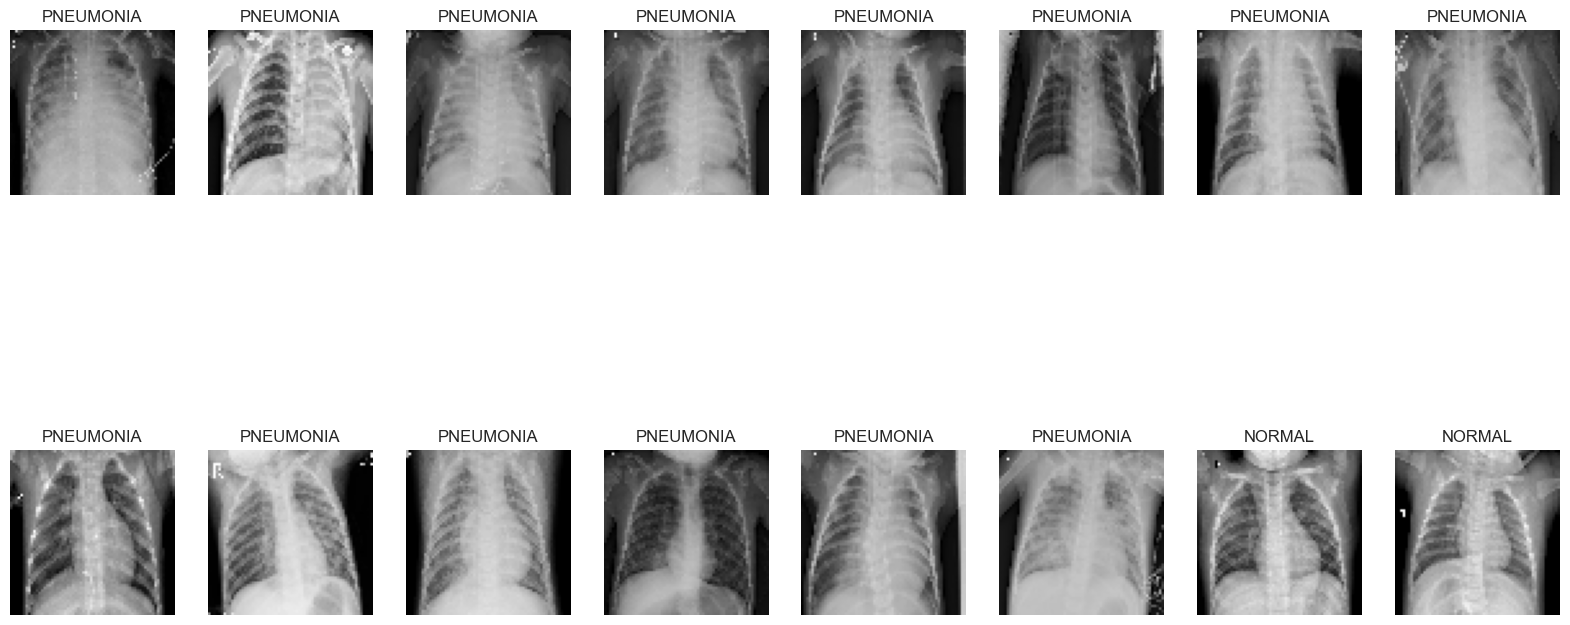

In [12]:
#plotting images of NORMAL and PNEUMONIA
plt.figure(figsize=(20,10))
for n , i in enumerate(np.random.randint(0,len(loaded_X_train),16)): 
    plt.subplot(2,8,n+1)
    plt.imshow(loaded_X_train[i])
    plt.axis('off')
    plt.title(getcode(loaded_y_train[i]))

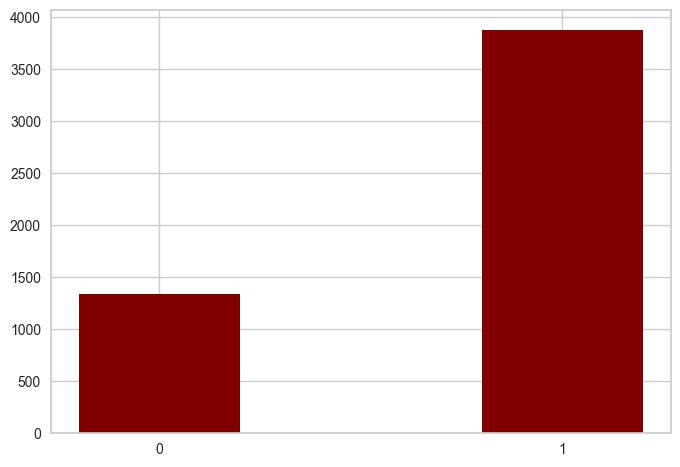

In [63]:
#count plot to show the number of pneumonia cases to normal cases in the train data set
df_train = pd.DataFrame()
df_train["labels"]= loaded_y_train
lab = df_train['labels']
dist = lab.value_counts()
dist = pd.DataFrame({'Label': dist.index, 'Count': dist.values})
plt.bar(dist['Label'], dist['Count'], color ='maroon', 
        width = 0.4, tick_label = dist['Label'])
plt.show()

In [45]:
def plotHistogram(a):
    plt.figure(figsize=(12, 6))
    
    # Display the grayscale image
    plt.subplot(1, 2, 1)
    plt.imshow(a, cmap='gray')
    plt.title('Grayscale Image Display', fontsize=15)

    # Histogram for the grayscale image
    histo = plt.subplot(1, 2, 2)
    histo.set_title('Pixel Intensity Distribution', fontsize=15)
    histo.set_ylabel('Count', fontsize=12)
    histo.set_xlabel('Pixel Intensity', fontsize=12)
    n_bins = 30

    # Plot histogram
    plt.hist(a[:,:,0].flatten(), bins=n_bins, lw=0, color='black', alpha=0.7)
    plt.hist(a[:,:,1].flatten(), bins=n_bins, lw=0, color='black', alpha=0.7)
    plt.hist(a[:,:,2].flatten(), bins=n_bins, lw=0, color='black', alpha=0.7)

    plt.tight_layout()  # Adjust the layout

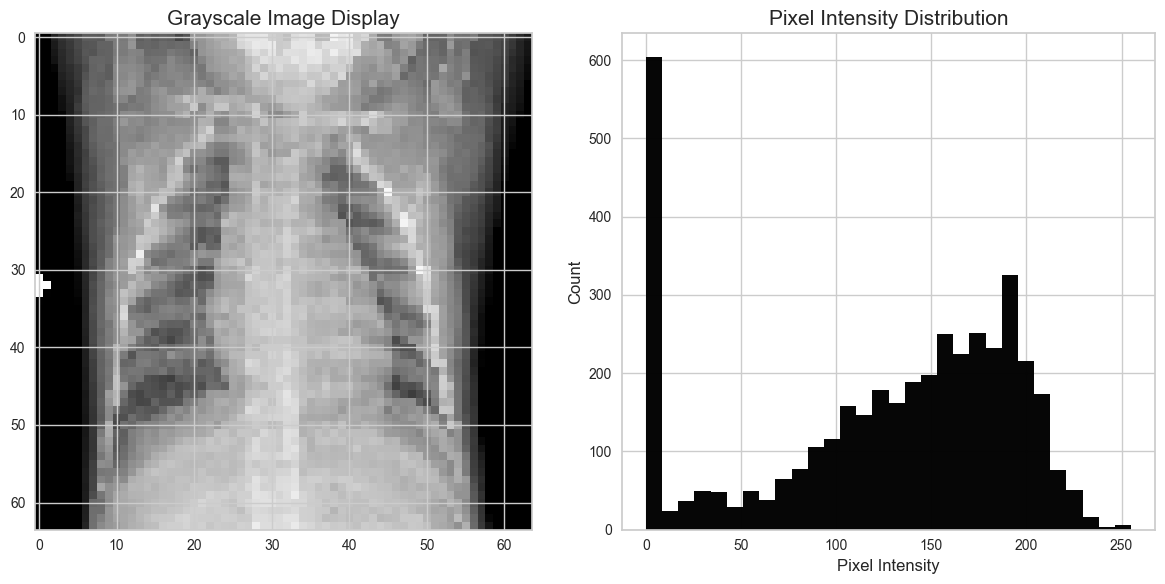

In [47]:
plotHistogram(loaded_X_train[np.random.randint(len(loaded_X_train))])

In [25]:
loaded_X_test = loaded_X_test[...,0]
loaded_X_train = loaded_X_train[...,0]


In [26]:
X_test = loaded_X_test.reshape(624, 64*64)
X_train = loaded_X_train.reshape(5216, 64*64)

In [27]:
print(X_train.shape)
print(X_test.shape)

(5216, 4096)
(624, 4096)


In [28]:
y_train = loaded_y_train
y_test = loaded_y_test

In [29]:
#shuffle train and test data sets in a consistent way
X_train, y_train = shf(X_train, y_train, random_state=123)
X_test, y_test = shf(X_test, y_test, random_state=123)

In [30]:
#Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

### Principal Component Analysis (PCA) with Prinipal Component Regression (PCR)

In [36]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

num_components_PCA = np.arange(10, 200, 10)
kfold = skm.KFold(n_splits=5, shuffle=True, random_state=123)

best_num_components = None
best_val_accuracy = 0
pcr_val_accuracy = []

for n in num_components_PCA:
    # Create a pipeline with PCA and logistic regression
    pca = PCA(n_components=n)
    logistic_reg = LogisticRegression()
    pipe = Pipeline([('pca', pca), ('logistic', logistic_reg)])

    scores = cross_val_score(pipe, X_train, y_train, cv=kfold, scoring='accuracy')

    mean_accuracy = np.mean(scores)
    pcr_val_accuracy.append(mean_accuracy)

    if mean_accuracy > best_val_accuracy:
        best_val_accuracy = mean_accuracy
        best_num_components = n

# After the loop, best_num_components will have the number of components with the highest mean accuracy
print(f"Best Number of Components: {best_num_components}, with an average accuracy of: {best_val_accuracy}")


Best Number of Components: 140, with an average accuracy of: 0.9593583202007178


In [42]:

pcr_val_error = 1 - np.array(pcr_val_accuracy)
bst_pcr_val_error = 1 - best_val_accuracy
print(f"Best Validation Error: {bst_pcr_val_error}")

Best Validation Error: 0.04064167979928224


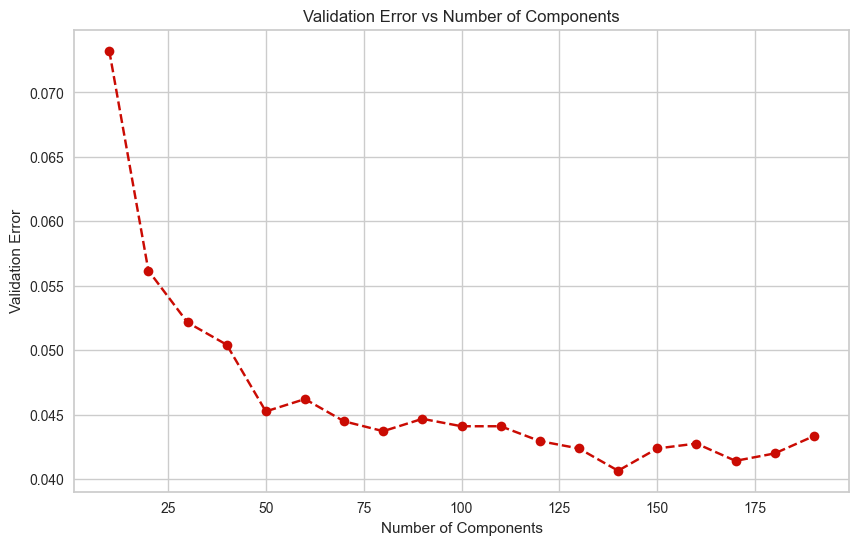

In [40]:
# Plot the validation error as a function of the number of components
plt.figure(figsize=(10,6))
plt.plot(np.arange(10, 200, 10), pcr_val_error, marker='o', linestyle='--', color='r')
plt.xlabel('Number of Components')
plt.ylabel('Validation Error')
plt.title('Validation Error vs Number of Components')
plt.show()


In [45]:
#Use the best number of components to fit the PCA model
pca = PCA(n_components=best_num_components)
pipe = Pipeline([('pca', pca), ('logistic', logistic_reg)])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)
print(f"Test Error of PCR using the best number of components(140): {1 - pipe.score(X_test, y_test)}")


Test Error of PCR using the best number of components(140): 0.21153846153846156


In [53]:
#function to plot the confusion matrix for each model
def plot_cm(predictions, y_test, title):
  labels = ['Normal', 'Pnuemonia']
  labels_predicted = ['Predicted Normal', 'Predicted Pnuemonia']
  labels_actual = ['Actual Normal', 'Actual Pnuemonia']
  cm = confusion_matrix(y_test,predictions)
  cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
  plt.figure(figsize = (8,8))
  plt.title(title)
  sns.heatmap(cm, linecolor = 'black' , linewidth = 2 , annot = True, fmt='', xticklabels = labels_predicted, yticklabels = labels_actual)
  plt.show()

In [49]:
pipe_pred_pcr = pipe.predict(X_test)


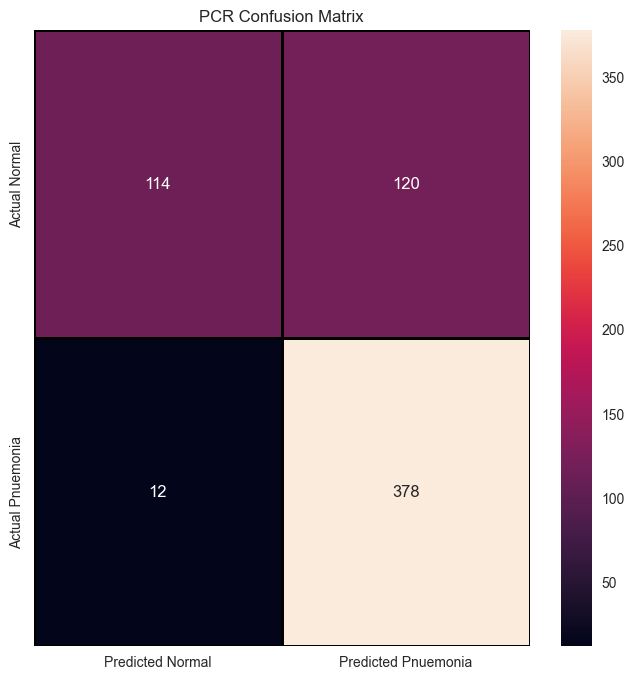

In [54]:
#plot confusion matrix for each model

plot_cm(pipe_pred_pcr, y_test, 'PCR Confusion Matrix')

In [55]:
smote = SMOTE(random_state=123)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(X_train_smote.shape)
print(y_train_smote.shape)

(7750, 4096)
(7750,)


In [56]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

num_components_PCA = np.arange(10, 200, 10)
kfold = skm.KFold(n_splits=5, shuffle=True, random_state=123)

best_num_components = None
best_val_accuracy = 0
pcr_val_accuracy = []

for n in num_components_PCA:
    # Create a pipeline with PCA and logistic regression
    pca = PCA(n_components=n)
    logistic_reg = LogisticRegression()
    pipe = Pipeline([('pca', pca), ('logistic', logistic_reg)])

    scores = cross_val_score(pipe, X_train_smote, y_train_smote, cv=kfold, scoring='accuracy')

    mean_accuracy = np.mean(scores)
    pcr_val_accuracy.append(mean_accuracy)

    if mean_accuracy > best_val_accuracy:
        best_val_accuracy = mean_accuracy
        best_num_components = n

# After the loop, best_num_components will have the number of components with the highest mean accuracy
print(f"Best Number of Components: {best_num_components}, with an average accuracy of: {best_val_accuracy}")

Best Number of Components: 190, with an average accuracy of: 0.967483870967742


In [58]:
print(f"Best Number of Components: {best_num_components}, with an average test error of: {1- best_val_accuracy}")

Best Number of Components: 190, with an average accuracy of: 0.03251612903225798


In [61]:
#Use the best number of components to fit the PCA model
pca = PCA(n_components=best_num_components)
pipe = Pipeline([('pca', pca), ('logistic', logistic_reg)])
pipe.fit(X_train_smote, y_train_smote)
pipe.score(X_test, y_test)
print(f"Test Error of PCR using the best number of components(190): {1 - pipe.score(X_test, y_test)}")

Test Error of PCR using the best number of components(190): 0.1891025641025641


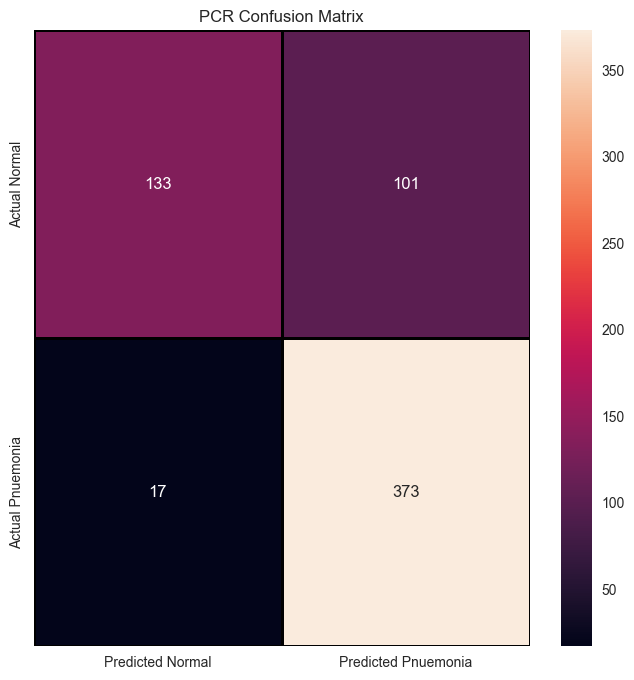

In [63]:
pipe_pred_pcr_smote = pipe.predict(X_test)
plot_cm(pipe_pred_pcr_smote, y_test, 'PCR Confusion Matrix')


### KNN

In [27]:
#Use cross validation to find the best number of neighbors, the range of k to consider
#includes the square root of the number of samples in the training set
num_components_knn = np.arange(1, 100, 1)
best_k = None
best_val_accuracy = 0
val_accuracy =[]

for k in num_components_knn:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=kfold, scoring='accuracy')
    mean_accuracy = np.mean(scores)
    val_accuracy.append(mean_accuracy)

    if mean_accuracy > best_val_accuracy:
        best_val_accuracy = mean_accuracy
        best_k = k
print(f"Best Number of Neighbors: {best_k}, with an average accuracy of: {best_val_accuracy}")



Best Number of Neighbors: 4, with an average accuracy of: 0.9396081521399735
Best Number of Neighbors: 4, with an average accuracy of: 0.9396081521399735


Text(0, 0.5, 'Validation Accuracy')

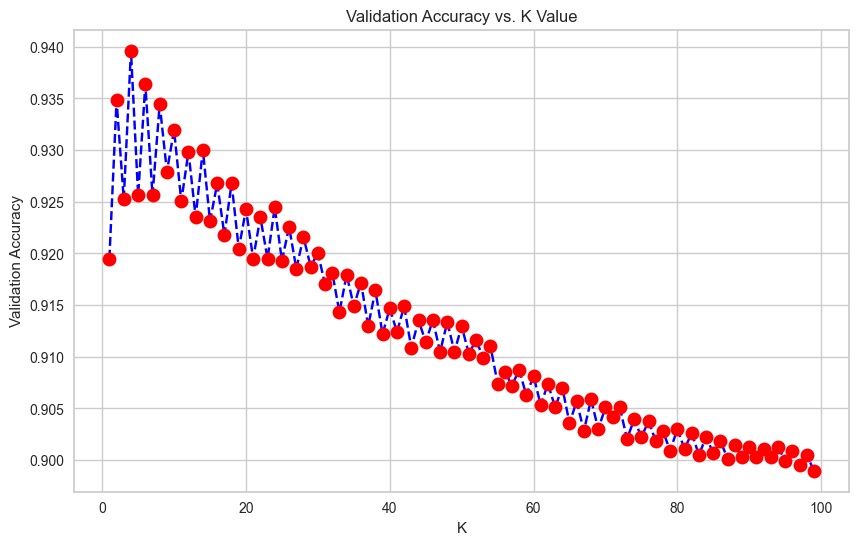

In [125]:
#Plot how the validation accuracy changes as k increases
plt.figure(figsize=(10,6))
plt.plot(num_components_knn, val_accuracy, color='blue', linestyle='dashed', marker='o',
            markerfacecolor='red', markersize=10)
plt.title('Validation Accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Validation Accuracy')


In [127]:
#Refit the model with the best K
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train, y_train)
print(f"Test Accuracy of KNN using the best number of neighbors(4): {knn.score(X_test, y_test)}")


Test Accuracy of KNN using the best number of neighbors(4): 0.7660256410256411


### Random Forest

In [113]:
number_of_trees = [10, 50, 100, 200]
best_number_trees = None
smallest_train_error = np.inf
smallest_test_error = np.inf
train_error_list = []
test_error_list = []
for n in number_of_trees:
    #Our max features are designed to be the square root of the number of samples
    RF_class = RFC(n_estimators=n, random_state=123, max_features=round(np.sqrt(X_train.shape[1])))
    RF_class.fit(X_train, y_train)
    RF_class_pred = RF_class.predict(X_test)

    train_error = 1 - accuracy_score(y_train, RF_class.predict(X_train))
    test_error = 1 - accuracy_score(y_test, RF_class_pred)

    train_error_list.append(train_error)
    test_error_list.append(test_error)

    if(train_error < smallest_train_error):
        smallest_train_error = train_error
    if(test_error < smallest_test_error):
        smallest_test_error = test_error
        best_number_trees = n


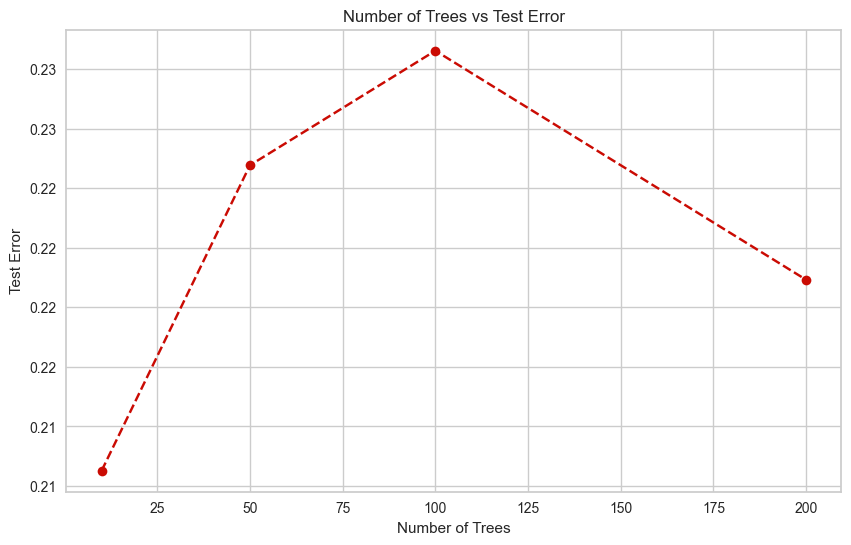

In [115]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

plt.figure(figsize=(10,6))
plt.plot(number_of_trees, test_error_list, marker='o', linestyle='--', color='r')

# Format the y-axis to display two decimal places
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

plt.xlabel('Number of Trees')
plt.ylabel('Test Error')
plt.title('Number of Trees vs Test Error')
plt.show()